In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import torch
from torch import nn
import torch_geometric as pyg
from torchmetrics import F1Score

# Cyclicity

In [4]:
dataset = CyclicityDataset(seed=12345)
train_data, val_data = dataset.train_test_split(k=10)
train_loader = train_data.loader(batch_size=128, shuffle=True)
val_loader = val_data.loader(batch_size=128, shuffle=False)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
dataset.describe()

{'mean_n': 52.76344180335058,
 'mean_m': 52.51504254012806,
 'std_n': 25.45414709419518,
 'std_m': 25.46061875996072}

data: Data(x=[96, 1], edge_index=[2, 192], edge_attr=[192, 2], y=[1], G=Graph with 96 nodes and 96 edges)
class: red_cyclic


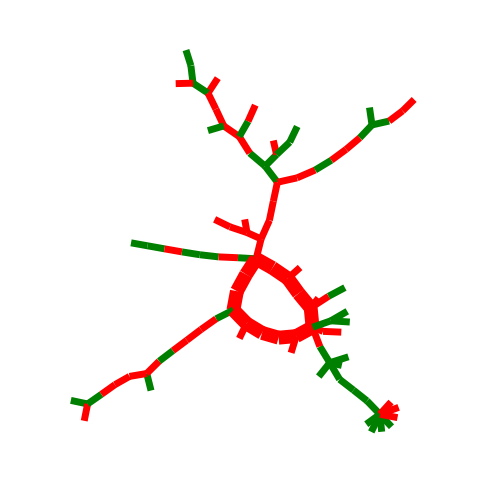

In [6]:
dataset.show(7)

# Train Model

In [7]:
model = NNConvClassifier(node_features=len(dataset.NODE_CLS),
                         edge_features=len(dataset.EDGE_CLS),
                         num_classes=len(dataset.GRAPH_CLS),
                         hidden_channels=32)

In [8]:
model.load_state_dict(torch.load('cyclicity_nnconv.pt'))

<All keys matched successfully>

In [9]:
train_data.evaluate_model(model)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'red_cyclic': 0.9628506302833557,
 'green_cyclic': 0.951839029788971,
 'acyclic': 0.9590314626693726}

In [10]:
val_data.evaluate_model(model)

{'red_cyclic': 0.9702276587486267,
 'green_cyclic': 0.9493243098258972,
 'acyclic': 0.9579229950904846}

In [15]:
mean_embeds = train_data.mean_embeddings(model)

In [16]:
mean_embeds

[tensor(1.1189), tensor(1.1823), tensor(1.7719)]

In [17]:
embeds = [[] for _ in range(len(train_data.GRAPH_CLS))]
model.eval()
for batch in train_data.loader(batch_size=32):
    for i, e in enumerate(model(batch)['embeds']):
        embeds[batch.y[i].item()].append(e)
embeds

[[tensor([-3.6175e-02, -2.6099e-02, -3.6053e-02,  6.5682e+00, -2.2891e-01,
          -8.4012e-02, -4.3749e-02, -1.8759e-02, -1.0192e-01, -9.8916e-02,
           1.4138e+00, -1.4813e-02, -3.9286e-02, -5.9051e-02, -2.2922e-02,
          -1.6685e-02, -3.3056e-02,  1.0226e+01, -2.9168e-03, -1.1582e-01,
          -2.4564e-01, -6.7504e-02, -4.8437e-03,  7.7290e+00, -3.0753e-02,
          -3.6491e-02, -2.4637e-02, -8.3562e-02, -2.1757e-01,  2.1844e+00,
          -2.4325e-02,  9.7175e-01], grad_fn=<UnbindBackward0>),
  tensor([-8.3218e-02, -6.6790e-02, -9.7113e-02,  1.0231e+01, -7.3604e-01,
          -2.7887e-01, -1.4633e-01, -9.8218e-02, -4.2854e-01, -3.2550e-01,
          -7.1784e-02, -5.7777e-02, -1.5539e-01, -1.3313e-01, -1.0062e-01,
          -3.5827e-02, -4.7800e-02,  1.5614e+01, -1.1664e-02, -3.4054e-01,
          -8.6256e-01, -2.1822e-01, -3.3629e-02,  1.1573e+01, -9.3822e-02,
          -1.4152e-01, -4.6330e-02, -2.6292e-01, -6.9650e-01,  7.1915e+00,
          -9.0973e-02, -2.8577e-03]

In [27]:
trainer = {}
sampler = {}

# 1

In [59]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    # NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    # NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=100), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=cyclicity,
                  k_samples=16)

In [60]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [61]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [62]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

n=11 m=18
logits=[-216.79331970214844, 558.6318359375, -311.3712463378906]
probs=[0.0, 1.0, 0.0]


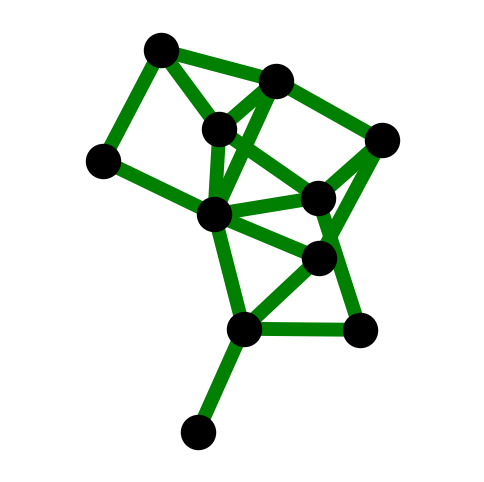

In [63]:
G = trainer[classes].evaluate(threshold=0.5, show=True)
plt.show()

# 2

In [92]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.1,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    # NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    # NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=25), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=15), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=cyclicity,
                           k_samples=16)

In [93]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [94]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [95]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=12
logits=[-15.828670501708984, -7.78698205947876, 3.6513009071350098]
probs=[3.4669809245713168e-09, 1.0774872862384655e-05, 0.9999892711639404]


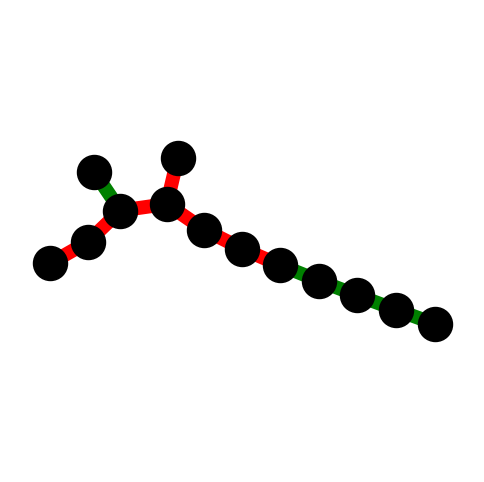

In [96]:
trainer[2].evaluate(threshold=0.5, show=True)

n=15 m=14
logits=[-8.079935073852539, -6.416947364807129, 3.0488319396972656]
probs=[1.4682427718071267e-05, 7.745050243102014e-05, 0.9999078512191772]


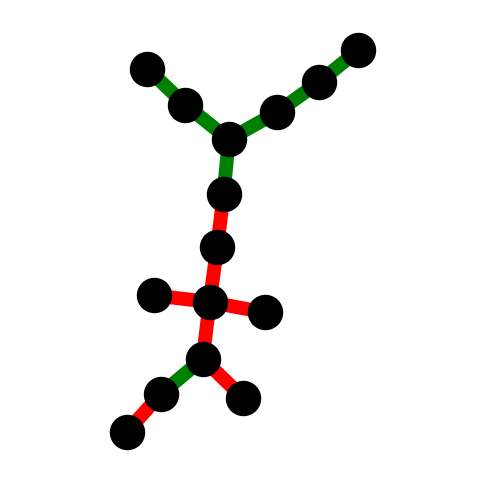

In [98]:
trainer[2].evaluate(bernoulli=True, show=True)

# 0

In [129]:
classes = 0
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    NormPenalty(lambda: s.eta, order=1, weight=1), # L1 penalty on eta
    NormPenalty(lambda: s.eta, order=2, weight=1), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=50), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=cyclicity,
                           k_samples=16)

In [130]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [131]:
trainer[0].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

n=17 m=28
logits=[587.2236938476562, -609.8198852539062, -626.7744750976562]
probs=[1.0, 0.0, 0.0]


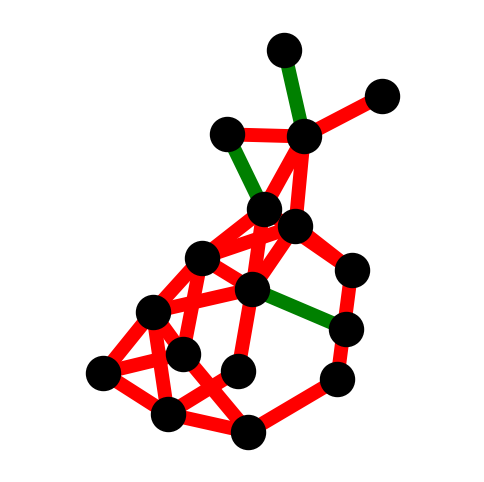

In [132]:
trainer[0].evaluate(threshold=0.5, show=True)

n=17 m=28
logits=[587.2236938476562, -609.8198852539062, -626.7744750976562]
probs=[1.0, 0.0, 0.0]


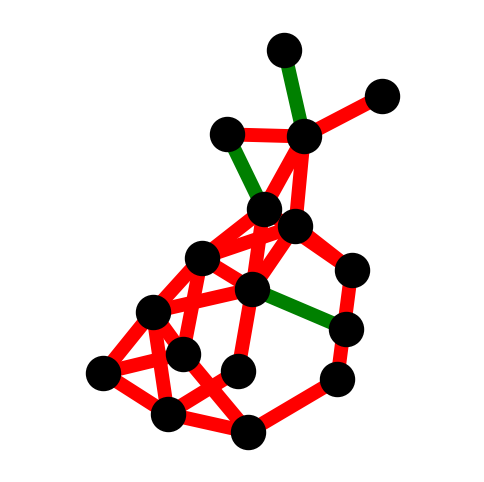

In [133]:
trainer[0].evaluate(bernoulli=True, show=True)